In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
# valores de tempo de execucao da rede
from time import time 
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor() #definindo a conversao de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega a parte de treino do datasets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #carrega um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega a parte de validacao do dataset
valloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #cria buffer para pegar os dados por partes


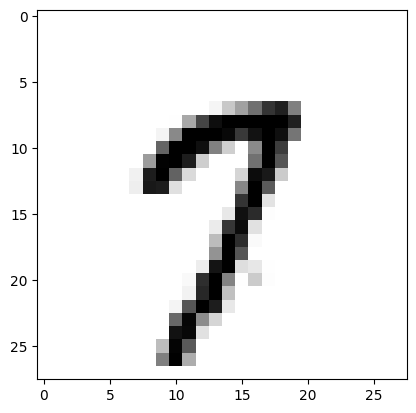

In [3]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [4]:
print(imagens[0].shape) #para verificar as dimensoes do tensor de cada imagem
print(etiquetas[0].shape) #para verificar as dimensoes do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [5]:
class Modelo(nn.Module):
    def __init__(self) -> None:
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 784 neuronios que se ligam a 128
        self.linear2 = nn.Linear(28*28, 128) #camada interna 1, 128 neuronios que se ligam a 63
        self.linear3 = nn.Linear(28*28, 128) #camada interna 2, 64 neuronios que se ligam a 10
        #para a camada de saida nao e necessario definir nada pois so precisam pegar o output da camada interna 2

    def foward(self, X):
        X = F.relu(self.linear1(X)) #funcao de ativacao da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) #funcao de ativacao da camada interna 1 para a camada interna 2
        X = self.linear3(X) #funcao de ativacao da camada interna 2 para a camada de saida, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) #dados utilizado para calcular a perda

In [6]:
def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #define a politica de atualizacao dos pesos e da bias
    inicio = time() #timer para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss() #definindo o criteiro para calcular a perda
    EPOCHS = 10 #numero de epochs que o algoritmo rodara
    modelo.train() #ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 #inicializacao da perda acumulada da epoch em questao

        for imagens, etiquetas in trainloader:
            imagens = imagens.view(imagens.shape[0], -1) #converte as imagens para "vetores" de 28*28 casas para ficarem compativeis 
            otimizador.zero_grad() #zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) #colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) #calculando a perda de epoch em questao

            perda_instantanea.backward() #back propagation a partir da perda

            otimizador.step() #atualizando os pesos da bias

            perda_acumulada += perda_instantanea.item() #atualizacao da perda acumulada

        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =", (time() - inicio)/60)

In [7]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            #desativa o autograd para acelerar a validacao. Grafos computacionais dinamicos tem um custo alto de processamento
            with torch.no_grad():
                loggps = modelo(img.to(device)) #output do modelo em escala logaritmica

            ps = torch.exp(loggps) #converte output para escala normal(um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max[probab]) #converte o tensor em um numero, o numero que o modelo previu como correto
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred):
                conta_corretas += 1
            conta_todas += 1
        
        print("Total de imagens testadas =", conta_todas)
        print("\nPrevisao do modelo={}%".format(conta_corretas*100/conta_todas))

In [10]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=784, out_features=128, bias=True)
  (linear3): Linear(in_features=784, out_features=128, bias=True)
)